# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [595]:
# Parameters
m = 3
A = 0.01#0.05#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [596]:
res=m;
N=2.0^m*500/10.0#1000.0#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx,digits=10);
Nt=2.0^m*500.0/10.0#100.0*2^m*10
Tf=Nt*dt; #final time
print(Tf)

1.0

In [597]:
print(N)

400.0

In [598]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.0025
dt =0.0025
dx/dt =1.0


In [599]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [600]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [601]:
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
#T=range(0,stop=Tf,step=dt)
println("the time step is ", dt)

step size is  0.0025
the time step is 0.0025


In [602]:
include("./ScalarField.jl");

# Initial data of m β Ψ and Ψ,x

In [603]:
using Dierckx

####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.01#0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], initderpsi[4:L-3],  k=4)

Spline1D(knots=[0.0,0.00625 … 0.99375,1.0] (398 elements), k=4, extrapolation="nearest", residual=0.0)

In [604]:
#x3= initX1
#y3=derpsi_func(initX1).-init_gaussian_der(initX1,r0,sigma,A);

In [605]:
#using Plots
#plot(x3, y3, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])

In [606]:
#########

In [607]:
aux=doublegrid(initX1)
derpsi_func(aux);

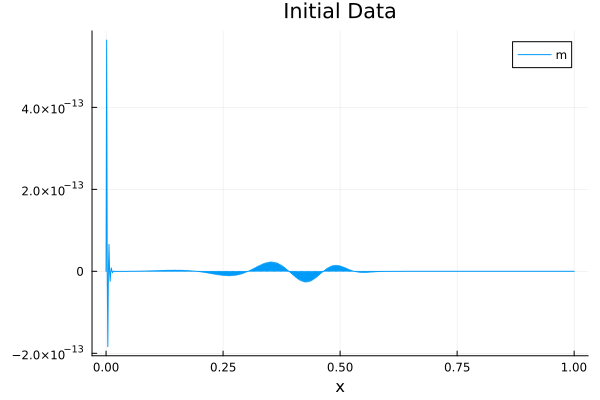

In [608]:
using Plots
plot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])

In [609]:
x3=aux
y3=derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A);

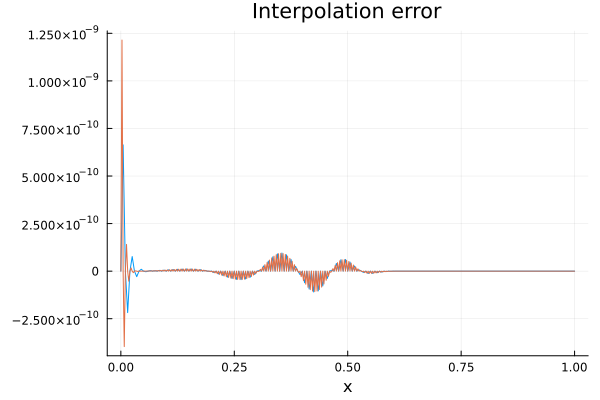

In [651]:
double_resolution=y2
basis_resolution=y1
xs = ( x1, x2 )
ys = ( basis_resolution, double_resolution*16*4 )
p = plot()
map(x->plot!(x[1],x[2],xaxis="x",title="Interpolation error", legend=false), zip(xs, ys))
display(p)

In [ ]:
###########

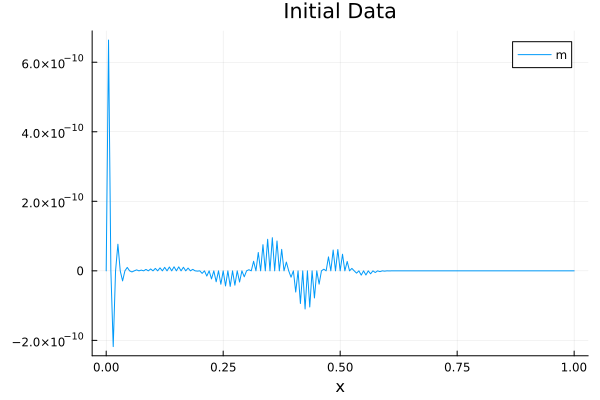

In [469]:
using Plots
plot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])

In [389]:
highinterp = derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A)

201-element Vector{Float64}:
  8.723749937527311e-5
  0.00011584828746670272
  0.00014103241849461329
  0.00016274668004950788
  0.00018095273184431132
  0.00019561832237502966
  0.00020671857566675482
  0.00021423734255281943
  0.000218168609329697
  0.0002185179548810037
  0.0002153040454755157
  0.0002085601544248899
  0.0001983356916492932
  ⋮
  5.397322457810429e-6
 -1.8394564279570688e-5
 -4.385326319270868e-5
 -7.102478832495351e-5
 -9.995564738177076e-5
 -0.0001306928417307422
 -0.00016328386640156477
 -0.0001977767100860514
 -0.00023421985513813064
 -0.0002726622775738466
 -0.00031315344707135936
 -0.0003557433269709444

In [390]:
lowinterp = derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A)

"""using Plots
plot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])"""

"using Plots\nplot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis=\"x\",title=\"Initial Data\", labels=[\"m\" \"beta\" \"psi\" \"psi,x\"])#, ylim=[0, 10^(-13)])"

In [391]:
using Plots
plot(aux, [lowinterp 16*highinterp[1:2:length(highinterp)]], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])

LoadError: DimensionMismatch: vectors must have same lengths

In [392]:
highinterp[1:2:length(highinterp)];

In [393]:
y0=[0 0 0]
state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func)

state_array = ghost(state_array);

In [397]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], [state_array[4:L-3,4].-derpsi_func(initX1)], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-7)])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX[4:L-3], [state_array[4:L-3,4].-derpsi_func(initX1)], xaxis=\"x\",title=\"Initial Data\", labels=[\"m\" \"beta\" \"psi\" \"psi,x\"])#, ylim=[0, 10^(-7)])"

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [395]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

In [376]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [377]:
ginit=dt_scale(initX,state_array[:,1],state_array[:,2],dx)
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

1.0


 ## Time evolution

fixed grid

In [508]:
finaltime=1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,dir*"/res$res",run);
CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);

iteration 10 dt is 0.0025, time of iteration is 0.025
iteration 20 dt is 0.0025, time of iteration is 0.05
iteration 30 dt is 0.0025, time of iteration is 0.075
iteration 40 dt is 0.0025, time of iteration is 0.1
iteration 50 dt is 0.0025, time of iteration is 0.125
iteration 60 dt is 0.0025, time of iteration is 0.15
iteration 70 dt is 0.0025, time of iteration is 0.175
iteration 80 dt is 0.0025, time of iteration is 0.2
iteration 90 dt is 0.0025, time of iteration is 0.225
iteration 100 dt is 0.0025, time of iteration is 0.25
iteration 110 dt is 0.0025, time of iteration is 0.275
iteration 120 dt is 0.0025, time of iteration is 0.3
iteration 130 dt is 0.0025, time of iteration is 0.325
iteration 140 dt is 0.0025, time of iteration is 0.35
iteration 150 dt is 0.0025, time of iteration is 0.375
iteration 160 dt is 0.0025, time of iteration is 0.4
iteration 170 dt is 0.0025, time of iteration is 0.425
iteration 180 dt is 0.0025, time of iteration is 0.45
iteration 190 dt is 0.0025, time

 ## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
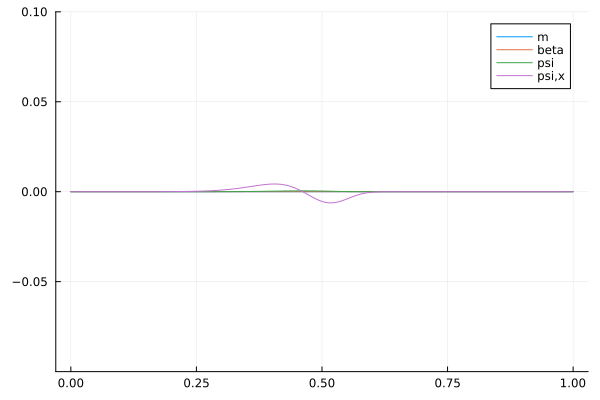

In [463]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 0:1:200
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], ylim=[-0.1, 0.1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 20)

In [432]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:290#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2/monitor_ratio10.csv" is not a valid file or doesn't exist

In [51]:
epsilon(dt,dx)

0.015625

In [52]:
iteration 5010 dt is 8.107532615016511e-12, time of iteration is 0.6658624521770952
iteration 5020 dt is 1.4603412731963235e-12, time of iteration is 0.665862452213098
Supercritical evolution! At time 0.6658624522174752
Gridpoint = 251 t = 0.6658624522174752 monitor ratio = 1.0015530116841327

LoadError: syntax: extra token "5010" after end of expression